# **Random Forest Implementation**

## Installing and Importing Packages

The required packages are installed and imported.

In [1]:
#Installing packages

# !pip install matplotlib
# !pip install scikit-learn

In [2]:
#Importing packages
import kagglehub
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import ast
import pickle
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

## Installing Dataset

Downloading the dataset, retrieving its path and displaying the head and size.

In [3]:
#Downloading the dataset
path = kagglehub.dataset_download("ivanhrek/uci-adult")

In [4]:
#Retrieving the path to the dataset
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        path = os.path.join(dirname, filename)

In [5]:
#Displaying the first 5 rows of the dataset
df = pd.read_csv(path)
df.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [6]:
print("Dataset Row Count:", len(df))

Dataset Row Count: 32561


In [7]:
#General Dataset Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  salary          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [8]:
#Unique values count in each column
df.nunique()

age                  73
workclass             9
fnlwgt            21648
education            16
education-num        16
marital-status        7
occupation           15
relationship          6
race                  5
sex                   2
capital-gain        119
capital-loss         92
hours-per-week       94
native-country       42
salary                2
dtype: int64

## Deciding Label to be Predicted

The ``salary`` label was decided to be the predicted value.

In [9]:
#Setting the target variable
label = 'salary'

## Data Cleaning

Performing Data Cleaning techniques to prepare the dataset for model training.

**Removing Duplicate Rows**

In [10]:
#Removing duplicate rows
print("Dataset Size before Deduplication: ", len(df))
deDupDF = df.drop_duplicates(inplace=False)
print("Dataset Size after Deduplication: ", len(deDupDF))

Dataset Size before Deduplication:  32561
Dataset Size after Deduplication:  32537


**Removing Null Value Rows** 

In [11]:
#Removing rows with missing values
print("Dataset Size after Null Removal: ", len(deDupDF))
#Replacing all missing values with NaN
noNullDF = deDupDF.replace('?', np.nan, inplace=False)
#Dropping rows with any NaN values
noNullDF = noNullDF.dropna(inplace=False)
#Resetting index after dropping rows
noNullDF = noNullDF.reset_index(drop=True, inplace=False)
print("Dataset Size after Null Removal: ", len(noNullDF))

Dataset Size after Null Removal:  32537
Dataset Size after Null Removal:  30139


**Removing Native Country Column**

The ``native-country`` was decided to be removed due to severe skewness, with the majority of rows having __United-States__ as a value.

In [12]:
#Removing the native-country column
print("Dataset Size before native-country Removal: ", len(noNullDF))
#Filtering rows with native-country as United-States
noCountryDF = noNullDF[noNullDF["native-country"] == "United-States"]
#Dropping the column
noCountryDF = noCountryDF.drop(columns=["native-country"], inplace=False)
print("Dataset Size after native-country Removal: ", len(noCountryDF))

Dataset Size before native-country Removal:  30139
Dataset Size after native-country Removal:  27487


**Removing Final Weight and Education Column**

The ``fnlwgt`` column was seen to be redundant, hence it was removed. ``Explain reason why it was removed.``

The ``education`` column is not needed as its already ordinally encoded in the ``education-num`` column. 

In [13]:
#Removing the fnlwgt and education columns
print("Original Columns: ", noCountryDF.columns)
noExtraColumnsDF = noCountryDF.drop(columns=["fnlwgt", "education"], inplace=False)
print("New Columns: ", noExtraColumnsDF.columns)

Original Columns:  Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'salary'],
      dtype='object')
New Columns:  Index(['age', 'workclass', 'education-num', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
       'hours-per-week', 'salary'],
      dtype='object')


**Performing One-Hot Encoding**

This technique was required since the ``workclass``, ``marital-status``, ``occupation``, ``relationship``, and ``race`` are all non-ordinal non-binary categorical classes.

The ``drop_first`` function drops one of the columns created from One-Hot Encoding to avoid the **Dummy Variable Trap**, which occurs when you have **Multicollinearity**. This phenomenon occurs when one of the new columns can be perfectly predicted by the others (i.e., if you know the values of n-1 columns, you can deduce the nth column). This can distort the model’s interpretation and lead to redundant information.

In [14]:
#Applying one-hot encoding to multiple categorical columns with drop_first to avoid the dummy variable trap
oHEDF = pd.get_dummies(noExtraColumnsDF, columns=['workclass', 'marital-status', 'occupation', 'relationship', 'race'], drop_first=True)
print("Original Columns: ", noExtraColumnsDF.columns)
print("New Columns: ", oHEDF.columns)
oHEDF.head(5)

Original Columns:  Index(['age', 'workclass', 'education-num', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
       'hours-per-week', 'salary'],
      dtype='object')
New Columns:  Index(['age', 'education-num', 'sex', 'capital-gain', 'capital-loss',
       'hours-per-week', 'salary', 'workclass_Local-gov', 'workclass_Private',
       'workclass_Self-emp-inc', 'workclass_Self-emp-not-inc',
       'workclass_State-gov', 'workclass_Without-pay',
       'marital-status_Married-AF-spouse', 'marital-status_Married-civ-spouse',
       'marital-status_Married-spouse-absent', 'marital-status_Never-married',
       'marital-status_Separated', 'marital-status_Widowed',
       'occupation_Armed-Forces', 'occupation_Craft-repair',
       'occupation_Exec-managerial', 'occupation_Farming-fishing',
       'occupation_Handlers-cleaners', 'occupation_Machine-op-inspct',
       'occupation_Other-service', 'occupation_Priv-house-serv',
       'occu

,age,education-num,sex,capital-gain,capital-loss,hours-per-week,salary,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,occupation_Transport-moving,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White
0,39,13,Male,2174,0,40,<=50K,False,False,False,...,False,True,False,False,False,False,False,False,False,True
1,50,13,Male,0,0,13,<=50K,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,38,9,Male,0,0,40,<=50K,False,True,False,...,False,True,False,False,False,False,False,False,False,True
3,53,7,Male,0,0,40,<=50K,False,True,False,...,False,False,False,False,False,False,False,True,False,False
5,37,14,Female,0,0,40,<=50K,False,True,False,...,False,False,False,False,False,True,False,False,False,True


**Converting Binary Categorical Columns**

The ``sex`` and ``salary`` columns are converted to integer values.

In [15]:
#Converting sex column to binary: Male -> 1, Female -> 0
binarySexDF = oHEDF.copy()
binarySexDF['sex'] = binarySexDF['sex'].map({'Male': 1, 'Female': 0})
#Checking the first few rows to confirm the conversion
binarySexDF.head(5)

,age,education-num,sex,capital-gain,capital-loss,hours-per-week,salary,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,occupation_Transport-moving,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White
0,39,13,1,2174,0,40,<=50K,False,False,False,...,False,True,False,False,False,False,False,False,False,True
1,50,13,1,0,0,13,<=50K,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,38,9,1,0,0,40,<=50K,False,True,False,...,False,True,False,False,False,False,False,False,False,True
3,53,7,1,0,0,40,<=50K,False,True,False,...,False,False,False,False,False,False,False,True,False,False
5,37,14,0,0,0,40,<=50K,False,True,False,...,False,False,False,False,False,True,False,False,False,True


In [16]:
#Converting 'salary' column to binary: >50K -> 1, <=50K -> 0
binarySalaryDF = binarySexDF.copy()
binarySalaryDF['salary'] = binarySalaryDF['salary'].map({'>50K': 1, '<=50K': 0})

#Checking the first few rows to confirm the conversion
binarySalaryDF.head(5)

,age,education-num,sex,capital-gain,capital-loss,hours-per-week,salary,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,occupation_Transport-moving,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White
0,39,13,1,2174,0,40,0,False,False,False,...,False,True,False,False,False,False,False,False,False,True
1,50,13,1,0,0,13,0,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,38,9,1,0,0,40,0,False,True,False,...,False,True,False,False,False,False,False,False,False,True
3,53,7,1,0,0,40,0,False,True,False,...,False,False,False,False,False,False,False,True,False,False
5,37,14,0,0,0,40,0,False,True,False,...,False,False,False,False,False,True,False,False,False,True


In [17]:
#Converting all columns to integer type
binarySalaryDF = binarySalaryDF.astype(int)
binarySalaryDF.head(5)

,age,education-num,sex,capital-gain,capital-loss,hours-per-week,salary,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,occupation_Transport-moving,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White
0,39,13,1,2174,0,40,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,50,13,1,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,38,9,1,0,0,40,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
3,53,7,1,0,0,40,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
5,37,14,0,0,0,40,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1


**Applying log1p to Highly-Skewed Columns** 

**log1p** is performed to reduce skewness of columns. The main reason this is used is due to the way it handles 0 values safely. When performing this technique, One-Hot Encoding columns can be ignored, as skewness is relevant only to traditional continuous values. If a column's skewness factors is not between -1 and 1, it is considered to be highly-skewed, thus **log1p** is performed.


In [18]:
#Getting only continuous columns
continuous_columns = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
continuousDF = binarySalaryDF[continuous_columns]

#Calculating skewness for continuous columns
skewness = continuousDF.skew()

#Checking skewness of the data
print(skewness)

#Filtering columns where skewness > 1 or skewness < -1
high_skew_columns = skewness[skewness > 1].index.tolist() + skewness[skewness < -1].index.tolist()

print("\nColumns with skewness > 1 or < -1:", high_skew_columns)
#Applying log transformation to reduce skewness
reducedSkewDF = binarySalaryDF.copy()
for column in high_skew_columns:
    reducedSkewDF[column] = np.log1p(reducedSkewDF[column])

#Checking the first few rows to confirm the transformation
reducedSkewDF.head(5)

age                0.516800
education-num     -0.076786
capital-gain      11.741257
capital-loss       4.474207
hours-per-week     0.319131
dtype: float64

Columns with skewness > 1 or < -1: ['capital-gain', 'capital-loss']


,age,education-num,sex,capital-gain,capital-loss,hours-per-week,salary,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,occupation_Transport-moving,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White
0,39,13,1,7.684784,0.0,40,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,50,13,1,0.000000,0.0,13,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,38,9,1,0.000000,0.0,40,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
3,53,7,1,0.000000,0.0,40,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
5,37,14,0,0.000000,0.0,40,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1


**Z-Score Normalisation**

This normalisation technique is used to rescale the data to have a **Mean of 0** and a **Standard Deviation of 1**. This is useful for models sensitive to feature scales, like SVMs, logistic regression, and k-means clustering.

In [19]:
#Initialising the scaler
scaler = StandardScaler()

#Creating a list of continuous columns to standardise
continuous_columns = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week'] 

#Removing the label column from the list of continuous columns
continuous_columns = [col for col in continuous_columns if col != label]

#Applying standardisation
zNormalisedDF = reducedSkewDF.copy()
zNormalisedDF[continuous_columns] = scaler.fit_transform(zNormalisedDF[continuous_columns])

#Saving the scaler using pickle to be used for unseen data
scaler_name = 'z-score_scaler_rf_salary_classification'
with open('models/'+scaler_name+'.pkl', 'wb') as f:
    pickle.dump(scaler, f)

#Checking the first few rows to confirm the standardisation
zNormalisedDF.head(5)

,age,education-num,sex,capital-gain,capital-loss,hours-per-week,salary,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,occupation_Transport-moving,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White
0,0.037475,1.167453,1,2.775700,-0.225273,-0.081047,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,0.872027,1.167453,1,-0.304276,-0.225273,-2.323808,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,-0.038394,-0.513895,1,-0.304276,-0.225273,-0.081047,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
3,1.099633,-1.354569,1,-0.304276,-0.225273,-0.081047,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
5,-0.114262,1.587790,0,-0.304276,-0.225273,-0.081047,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1


In [20]:
from sklearn.ensemble import RandomForestClassifier

# Splitting the data into training and validation sets
X = zNormalisedDF.drop(columns=[label]) 
y = zNormalisedDF[label]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Defining the parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20],      # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],    # Minimum samples required at a leaf node
    'bootstrap': [True, False]        # Whether bootstrap samples are used when building trees
}

# Initialising StratifiedKFold with 5 splits
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialising the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Initialising GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring='accuracy', cv=stratified_kfold, verbose=1, n_jobs=-1)

# Fitting the GridSearchCV to the training data
grid_search_rf.fit(X_train, y_train)

# Displaying the best model's hyperparameters
print("Best Hyperparameters:", grid_search_rf.best_params_)

# Retrieving the best model
best_rf_model = grid_search_rf.best_estimator_

# Predicting on the validation set
y_pred_rf = best_rf_model.predict(X_val)

# Evaluating the model
print("Accuracy:", accuracy_score(y_val, y_pred_rf))  
print("Classification Report:\n", classification_report(y_val, y_pred_rf))  
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_rf))  

# Saving the best model using pickle
model_name_rf = 'best_rf_Salary_Classification'
with open('models/' + model_name_rf + '.pkl', 'wb') as f:
    pickle.dump(best_rf_model, f)




Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Hyperparameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Accuracy: 0.8619497999272463
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.94      0.91      4135
           1       0.77      0.63      0.69      1363

    accuracy                           0.86      5498
   macro avg       0.83      0.79      0.80      5498
weighted avg       0.86      0.86      0.86      5498

Confusion Matrix:
 [[3877  258]
 [ 501  862]]


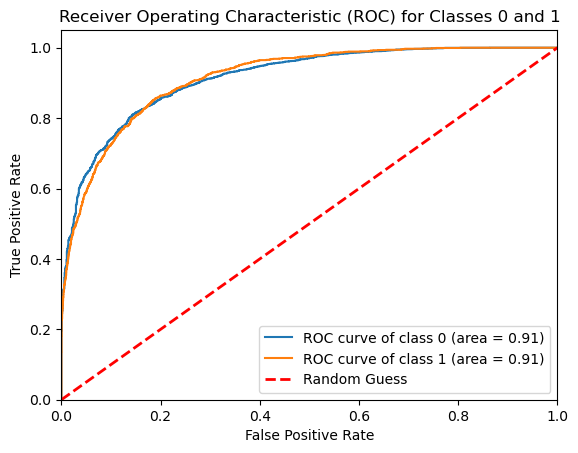

In [21]:
# Load the model
with open('models/best_rf_Salary_Classification.pkl', 'rb') as f:
    best_model = pickle.load(f)

# Predict probabilities for the validation set
y_prob_rf = best_rf_model.predict_proba(X_val)

# Initialize dictionaries to store ROC curve metrics for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate ROC curve and AUC for each class
for i in range(2):  # Assuming binary classification with classes 0 and 1
    fpr[i], tpr[i], _ = roc_curve(y_val == i, y_prob_rf[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for both classes
plt.figure()
for i in range(2):  # Two classes: 0 and 1
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

# Plotting the random guess line
plt.plot([0, 1], [0, 1], color="red", linestyle="--", lw=2, label="Random Guess")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Classes 0 and 1')
plt.legend(loc="lower right")
plt.show()


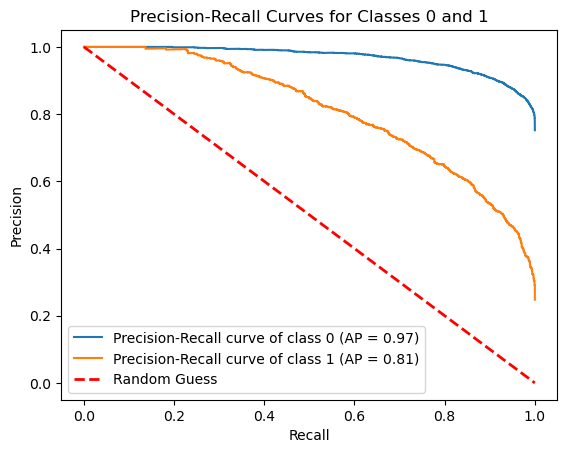

In [22]:
from sklearn.metrics import precision_recall_curve, auc

# Predict probabilities for the validation set
y_prob_rf = best_rf_model.predict_proba(X_val)

# Initialize dictionaries to store Precision-Recall metrics for each class
precision = dict()
recall = dict()
average_precision = dict()

# Calculate Precision-Recall curves for each class
for i in range(2):  # Assuming binary classification with classes 0 and 1
    precision[i], recall[i], _ = precision_recall_curve(y_val == i, y_prob_rf[:, i])
    average_precision[i] = auc(recall[i], precision[i])

# Calculate prior probability of each class (for baseline comparison)
class_priors = np.bincount(y_train) / len(y_train)

# Plot Precision-Recall curves for each class
plt.figure()
for i in range(2):  # Two classes: 0 and 1
    plt.plot(recall[i], precision[i], label='Precision-Recall curve of class {0} (AP = {1:0.2f})'
                                            ''.format(i, average_precision[i]))

# Plot the baseline (no skill)
plt.plot([0, 1], [1, 0], color="red", linestyle="--", lw=2, label="Random Guess")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Classes 0 and 1')
plt.legend(loc="lower left")
plt.show()


# Processing Unseen Data
Now that theRandom Forests have been trained, the models can now be trained on custom data.

**Validating Data**

In [23]:
#Creating a dictionary mapping the 'education' column to 'education-num' column using the specified string 
# (string was derived from the noCountryDF however its done manually here to avoid having to run all the prior code)
education_mapping = "{'Preschool': 1, '1st-4th': 2, '5th-6th': 3, '7th-8th': 4, '9th': 5, '10th': 6, '11th': 7, '12th': 8, 'HS-grad': 9, 'Some-college': 10, 'Assoc-voc': 11, 'Assoc-acdm': 12, 'Bachelors': 13, 'Masters': 14, 'Prof-school': 15, 'Doctorate': 16}"
education_dict = ast.literal_eval(education_mapping)

In [24]:
#Defining the validation functions for each column 
def validate_age(value):
    #Checking if the value is an integer and within the specified range
    return isinstance(value, int) and 0 <= value <= 100

def validate_workclass(value):
    #Checking if the value is in the specified list
    valid_workclasses = ['State-gov', 'Self-emp-not-inc', 'Private', 'Federal-gov', 'Local-gov', 'Self-emp-inc', 'Without-pay'] # 'Never-worked' didnt show up for me
    return value in valid_workclasses

def validate_education(value):
    #Checking if the value is in the specified list
    valid_education = ['Bachelors', 'HS-grad', '11th', 'Masters', 'Some-college', 'Assoc-acdm', 'Doctorate', '9th', 'Assoc-voc', '7th-8th', 'Prof-school', '10th', 'Preschool', '5th-6th', '12th', '1st-4th']
    return value in valid_education

def validate_marital_status(value):
    #Checking if the value is in the specified list
    valid_statuses = ['Never-married', 'Married-civ-spouse', 'Divorced', 'Separated', 'Married-AF-spouse', 'Widowed', 'Married-spouse-absent']
    return value in valid_statuses

def validate_occupation(value):
    #Checking if the value is in the specified list
    valid_occupations = ['Adm-clerical', 'Exec-managerial', 'Handlers-cleaners','Prof-specialty', 'Sales', 'Farming-fishing', 'Machine-op-inspct','Other-service', 'Transport-moving', 'Tech-support','Craft-repair', 'Protective-serv', 'Armed-Forces','Priv-house-serv']
    return value in valid_occupations

def validate_relationship(value):
    #Checking if the value is in the specified list
    valid_relationships = ['Not-in-family', 'Husband', 'Wife', 'Own-child', 'Unmarried', 'Other-relative']
    return value in valid_relationships

def validate_race(value):
    #Checking if the value is in the specified list
    valid_races = ['White', 'Black', 'Other', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo']
    return value in valid_races

def validate_sex(value):
    #Checking if the value is in the specified list
    return value in ['Male', 'Female']

def validate_capital_gain(value):
    #Checking if the value is an integer and within the specified range
    return  isinstance(value, int) and 0 <= value <= 99999 

def validate_capital_loss(value):
    #Checking if the value is an integer and within the specified range
    return  isinstance(value, int) and 0 <= value <= 4356  

def validate_hours_per_week(value):
    #Checking if the value is an integer and within the specified range
    return  isinstance(value, int) and 20 <= value <= 60  

def validate_salary(value):
    #Checking if the value is in the specified list
    return value in ['<=50K', '>50K']

#Defining function to validate the data
def validate_row(row, validation_functions):
    for col, value in row.items():
        if not validation_functions[col](value):
            return False  
    return True

#Defining function to append data if valid
def append_data(df, new_data, validation_functions):
    #Checking if new data is valid
    if validate_row(new_data, validation_functions):
        display(df)
        new_row_df = pd.DataFrame([new_data])
        #Appending the new data to the dataframe
        df = pd.concat([df, new_row_df], ignore_index=True)
        print("Data appended successfully!")
    else:
        print("Invalid data. Data was not appended.")
    return df

**Creating Unseen Example**

In [25]:
#Defining the columns and data types as per the required format
columns = ['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'salary'] # Features
#Defining the label column
label = 'salary' 

#Removing the label from the feature list and create an empty DataFrame with the specified columns
feature_list = [col for col in columns if col != label]
df = pd.DataFrame(columns=feature_list)

#Combining all validation functions in a dictionary
validation_functions = {
    'age': validate_age,
    'workclass': validate_workclass,
    'education': validate_education,
    'marital-status': validate_marital_status,
    'occupation': validate_occupation,
    'relationship': validate_relationship,
    'race': validate_race,
    'sex': validate_sex,
    'capital-gain': validate_capital_gain,
    'capital-loss': validate_capital_loss,
    'hours-per-week': validate_hours_per_week,
    # 'salary': validate_salary
}

#Removing the validation function for the label from the dictionary
validation_functions.pop(label, None)

#Taking example from the training data where salary <=50K
new_data = {
     'age': 60,
     'workclass': 'Self-emp-inc',
     'education': 'Bachelors',
     'marital-status': 'Widowed',
     'occupation': 'Tech-support',
     'relationship': 'Not-in-family',
     'race': 'White',
     'sex': 'Male',
     'capital-gain': 10000,
     'capital-loss': 0,
     'hours-per-week': 40,
     # 'salary': '>50K'
}

#Appending the data
df = append_data(df, new_data, validation_functions)

#Mapping the edcuational values to their corresponding numerical values
if label != 'education':
    #Replacing the 'education' column with its corresponding 'education-num' values
    df['education'] = df['education'].map(education_dict)
    df = df.rename(columns={'education': 'education-num'})

#Displaying the resulting DataFrame
display(df)

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week


Data appended successfully!


,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week
0,60,Self-emp-inc,13,Widowed,Tech-support,Not-in-family,White,Male,10000,0,40


**Dropping Label Columns**

In [26]:
#Creating a list of the columns present in dataframe used to train the model
columns = ['age', 'education-num', 'sex', 'capital-gain', 'capital-loss',
           'hours-per-week', 'workclass_Local-gov', 'workclass_Private',
           'workclass_Self-emp-inc', 'workclass_Self-emp-not-inc',
           'workclass_State-gov', 'workclass_Without-pay',
           'marital-status_Married-AF-spouse', 'marital-status_Married-civ-spouse',
           'marital-status_Married-spouse-absent', 'marital-status_Never-married',
           'marital-status_Separated', 'marital-status_Widowed',
           'occupation_Armed-Forces', 'occupation_Craft-repair',
           'occupation_Exec-managerial', 'occupation_Farming-fishing',
           'occupation_Handlers-cleaners', 'occupation_Machine-op-inspct',
           'occupation_Other-service', 'occupation_Priv-house-serv',
           'occupation_Prof-specialty', 'occupation_Protective-serv',
           'occupation_Sales', 'occupation_Tech-support',
           'occupation_Transport-moving', 'relationship_Not-in-family',
           'relationship_Other-relative', 'relationship_Own-child',
           'relationship_Unmarried', 'relationship_Wife',
           'race_Asian-Pac-Islander', 'race_Black', 'race_Other', 'race_White',
           'salary']

#Creating an empty DataFrame with these columns
formattedDF = pd.DataFrame(columns=columns)

#Dropping columns that contain the label in their name (These are not required as this will be what is predicted)
formattedDF = formattedDF.loc[:, ~formattedDF.columns.str.contains(label)]

print(formattedDF)

Empty DataFrame
Columns: [age, education-num, sex, capital-gain, capital-loss, hours-per-week, workclass_Local-gov, workclass_Private, workclass_Self-emp-inc, workclass_Self-emp-not-inc, workclass_State-gov, workclass_Without-pay, marital-status_Married-AF-spouse, marital-status_Married-civ-spouse, marital-status_Married-spouse-absent, marital-status_Never-married, marital-status_Separated, marital-status_Widowed, occupation_Armed-Forces, occupation_Craft-repair, occupation_Exec-managerial, occupation_Farming-fishing, occupation_Handlers-cleaners, occupation_Machine-op-inspct, occupation_Other-service, occupation_Priv-house-serv, occupation_Prof-specialty, occupation_Protective-serv, occupation_Sales, occupation_Tech-support, occupation_Transport-moving, relationship_Not-in-family, relationship_Other-relative, relationship_Own-child, relationship_Unmarried, relationship_Wife, race_Asian-Pac-Islander, race_Black, race_Other, race_White]
Index: []

[0 rows x 40 columns]


**Mapping the data from the input DF to the formattedDF**

In [27]:
#Copying over the continuous columns
if label != 'age':
    formattedDF['age'] = df['age']
if label != 'education-num' and label != 'education':
    formattedDF['education-num'] = df['education-num']
if label != 'capital-gain':
    formattedDF['capital-gain'] = df['capital-gain']
if label != 'capital-loss':
    formattedDF['capital-loss'] = df['capital-loss']
if label != 'hours-per-week':
    formattedDF['hours-per-week'] = df['hours-per-week']
if label != 'workclass':
    formattedDF['workclass_'+df['workclass']] = 1
if label != 'marital-status':
    formattedDF['marital-status_'+df['marital-status']] = 1
if label != 'occupation':
    formattedDF['occupation_'+df['occupation']] = 1
if label != 'relationship':
    formattedDF['relationship_'+df['relationship']] = 1
if label != 'race':
    formattedDF['race_'+df['race']] = 1
if label != 'sex':
    formattedDF['sex'] = formattedDF['sex'].apply(lambda x: 1 if x == 'Male' else 0)
if label != 'salary':
    formattedDF['salary'] = formattedDF['salary'].apply(lambda x: 1 if x == '>50K' else 0)


#Filling in the remaining columns with 0 and converting to integer type
formattedDF.fillna(0, inplace=True)
formattedDF = formattedDF.astype(int)

#Keeping only the columns present in the training data (removing columns that were dropped during one-hot encoding due to drop_first = True)
formattedDF = formattedDF[formattedDF.columns.intersection(columns)]

#Displaying the formatted DataFrame
display(formattedDF)

,age,education-num,sex,capital-gain,capital-loss,hours-per-week,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,occupation_Transport-moving,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White
0,60,13,0,10000,0,40,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1


**Applying log1p to the skewed models identified during training**


In [28]:
#Checking if the data / model changes these need to be updated
high_skew_columns = ['capital-gain', 'capital-loss']

#Assuming 'high_skew_columns' from training is a list of columns with high skewness
for column in high_skew_columns:
    formattedDF[column] = np.log1p(formattedDF[column])

**Applying the training scaler to the unseen data**

In [29]:
#Loading the scaler and transform the data
with open('models/z-score_scaler_rf_salary_classification.pkl', 'rb') as f:
    scaler = pickle.load(f)

#Creating a list of continuous columns to standardize
continuous_columns = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

#Removing the label column from the list of continuous columns
continuous_columns = [col for col in continuous_columns if col != label]
if label == 'education':
    continuous_columns.remove('education-num')

#Applying the scaler to the unseen data
formattedDF[continuous_columns] = scaler.transform(formattedDF[continuous_columns])

formattedDF.head(5)

,age,education-num,sex,capital-gain,capital-loss,hours-per-week,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,occupation_Transport-moving,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White
0,1.630712,1.167453,0,3.387167,-0.225273,-0.081047,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1


In [30]:
if label != 'salary':
    #Moving salary to be the seventh column
    column_order = list(formattedDF.columns)
    column_order.remove('salary')  # Remove 'salary' from current position
    column_order.insert(5, 'salary')  # Insert 'salary' at the seventh position (index 6)
    formattedDF = formattedDF[column_order]
    formattedDF.head(5)

In [31]:
#Inverting the education_dict to map the 'education-num' values back to 'education' values
inverse_mapping_education_num = {
    1: 'Preschool - 12th',
    2: 'HS Graduate',
    3: 'College',
    4: 'Associate Vocational - Bachelors',
    5: 'Master - Doctorate',
}

**Make prediction on new data using Best Model**

In [32]:
#Loading the saved model using pickle
if label == 'education':
    with open('models/best_rf_Education_Classification.pkl', 'rb') as f:
        loaded_model = pickle.load(f)
elif label == 'salary':
    with open('models/best_rf_Salary_Classification.pkl', 'rb') as f:
        loaded_model = pickle.load(f)

#Making predictions with the loaded model
prediction = loaded_model.predict(formattedDF)

if label == 'education':
    #Mapping the predicted values back to the original education values
    prediction = prediction[0]
    prediction = inverse_mapping_education_num[prediction]
elif label == 'salary':
    #Converting the prediction to the original salary classes
    prediction = '<=50K' if prediction[0] == 0 else '>50K'
elif label == 'sex':
    #Converting the prediction to the original sex classes
    prediction = 'Female' if prediction[0] == 0 else 'Male'


predicted_label = label
if label == 'education-num':
    #Mapping the predicted values back to the original education values
    predicted_label = 'education'


#Displaying the predicted salary class
print("Predicted " + predicted_label + " Class:", prediction)

Predicted salary Class: >50K
